In [1]:
import pandas as pd
import numpy as np
from divexplorer.FP_DivergenceExplorer import FP_DivergenceExplorer
from divexplorer.interactive import selectItemsInteractive


from import_datasets import *
ITEMSETS=["support", "itemsets", "tn", "tp", "fn", "fp"]
#ADDIT_DIVER_METRICS=["d_fpr","d_fpr_abs", "d_fnr", "d_fnr_abs", "d_accuracy", "SPsf", "FPsf","FNsf","ACsf"] 
#DIVERGENCE_METRICS=["d_fpr", "d_fnr", "d_accuracy"] 
#CLASSIFICATION_METRICS=["fpr", "fnr", "accuracy"]
#T_VALUES=["t_value_fp", "t_value_fn", "t_value_tp_tn"]
#INFOS=ITEMSETS+CLASSIFICATION_METRICS+DIVERGENCE_METRICS+T_VALUES
pd.set_option('display.max_colwidth', None)

# Dataset 

In [2]:
abbreviations = {"age_cat":"age", "priors_count":"#prior", "Greater than 45":">45", "25 - 45":"25-45",\
                "African-American":"Afr-Am", "c_charge_degree":"charge", "Less than 25":"<25", "=>":">", "=<":"<",\
                "length_of_stay":"stay", "Caucasian":"Cauc"} 

dataset_name="compas"
risk_class_type=True

Probublica analysis https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm

In [3]:
if dataset_name=="compas":
    dfI, class_map =import_process_compas(risk_class=risk_class_type)
    dfI.reset_index(drop=True, inplace=True)
    display(dfI.head(3))
elif dataset_name=="heart":
    dfI, class_map=import_process_heart()
    display(dfI.head(3))
elif dataset_name=="bank":
    dfI, class_map=import_process_bank()
    display(dfI.head(3))
elif dataset_name=="adult":
    dfI, class_map=import_process_adult()
    display(dfI.head(3))
elif dataset_name=="german":
    dfI, class_map=import_process_german()
    display(dfI.head(3))

/home/eliana/Projects/DivExplorerG/divexplorer/notebooks/import_datasets.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['length_of_stay'] = ((pd.to_datetime(df_raw['c_jail_out']).dt.date - pd.to_datetime(df_raw['c_jail_in']).dt.date).dt.days)


,age_cat,c_charge_degree,race,sex,class,priors_count,length_of_stay,predicted
0,Greater than 45,F,Other,Male,0,0,1.0,Medium-Low
1,25 - 45,F,African-American,Male,1,0,10.0,Medium-Low
2,Less than 25,F,African-American,Male,1,4,1.0,Medium-Low


In [4]:
print(f"Number of instances: {len(dfI)}, number of features: {len(dfI.columns)-1}")

Number of instances: 6172, number of features: 7


In [5]:
dfI["predicted"]= dfI['predicted'].replace({"Medium-Low":0, "High":1})

In [6]:
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(dfI["class"], dfI["predicted"]))

Accuracy:  0.6339922229423202


In [7]:
attributes=dfI.columns.drop(["class", "predicted"])
X_FP=dfI[attributes]
y_FP=dfI[["class"]]
y_predict_prob=None
y_predicted=np.asarray(dfI["predicted"])

In [8]:
X_FP=dfI[attributes].copy()
X_discretized=discretize(dfI, attributes=attributes, dataset_name=dataset_name)

print("X_discretized")
display(X_discretized.head())

X_discretized


,age_cat,c_charge_degree,race,sex,priors_count,length_of_stay
0,Greater than 45,F,Other,Male,0,<week
1,25 - 45,F,African-American,Male,0,1w-3M
2,Less than 25,F,African-American,Male,>3,<week
3,25 - 45,M,Other,Male,0,<week
4,25 - 45,F,Caucasian,Male,>3,<week


In [9]:
X_discretized["class"]=y_FP["class"]
X_discretized["predicted"]=y_predicted

# Extract divergence

In [10]:
# Input: 
# discretized dataframe
# true class
# predicted class  (opt)

# If input just one class --> positive rate and negative rate

True class and predicted class (column names as parameters)

In [11]:
min_sup=0.1
metrics=["d_fpr", "d_fnr", "d_accuracy", "d_error"]
fp_diver=FP_DivergenceExplorer(X_discretized,"class", "predicted", class_map=class_map, dataset_name=dataset_name)
FP_fm=fp_diver.getFrequentPatternDivergence(min_support=min_sup, metrics=metrics)

In [12]:
print(f"Number of frequent patterns: {len(FP_fm)}")

Number of frequent patterns: 155


In [13]:
FP_fm.sort_values("support", ascending=False).head(5)

,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,fnr,accuracy,error,d_fnr,d_fpr,d_accuracy,d_error,t_value_fp,t_value_fn,t_value_tp_tn,t_value_fp_fn
0,1.000000,(),3066,297,1962,847,0,6172.0,0.088314,0.698469,0.633992,0.366008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.809624,(sex=Male),2357,244,1647,749,1,4997.0,0.093810,0.687396,0.621573,0.378427,-0.011074,0.005496,-0.012419,0.012419,0.738697,0.864525,1.350598,1.350598
2,0.772683,(length_of_stay=<week),2589,201,1487,492,1,4769.0,0.072043,0.751390,0.646047,0.353953,0.052920,-0.016271,0.012055,-0.012055,2.339352,4.059364,1.301787,1.301787
3,0.643227,(c_charge_degree=F),1772,214,1307,677,1,3970.0,0.107754,0.658770,0.616877,0.383123,-0.039699,0.019440,-0.017116,0.017116,2.301183,2.896145,1.738770,1.738770
4,0.614226,"(length_of_stay=<week, sex=Male)",1959,162,1236,434,2,3791.0,0.076379,0.740120,0.631232,0.368768,0.041651,-0.011935,-0.002760,0.002760,1.555571,3.011311,0.280104,0.280104


# Divergence

In [14]:
saveFig=False
outDirShap="./results/figures/shap"
outDirLattice="./results/figures/lattice"

if saveFig:
    createDir(outDirShap)
    createDir(outDirLattice)

In [15]:
from divexplorer.FP_Divergence import FP_Divergence,abbreviateDict

## False positive rate

In [16]:
fp_divergence_ofI=FP_Divergence(FP_fm, "d_fpr")

In [17]:
INFOS=ITEMSETS+[fp_divergence_ofI.metric, fp_divergence_ofI.metric_name.lower(), fp_divergence_ofI.t_value_col]

In [18]:
fp_divergence_ofI.getInfoItemset(frozenset())[INFOS]

,support,itemsets,tn,tp,fn,fp,d_fpr,fpr,t_value_fp
0,1.0,(),3066,847,1962,297,0.0,0.088314,0.0


### Top K

In [19]:
fp_divergence_ofI.getDivergence(th_redundancy=0)[INFOS].head(10)

,support,itemsets,tn,tp,fn,fp,d_fpr,fpr,t_value_fp
112,0.128645,"(priors_count=>3, race=African-American, sex=Male, age_cat=25 - 45)",155,302,268,69,0.219722,0.308036,7.116857
92,0.145010,"(race=African-American, priors_count=>3, age_cat=25 - 45)",185,333,298,79,0.210928,0.299242,7.448260
135,0.109527,"(race=African-American, c_charge_degree=F, priors_count=>3, age_cat=25 - 45)",137,264,219,56,0.201841,0.290155,6.201585
109,0.130752,"(priors_count=>3, race=African-American, c_charge_degree=F, sex=Male)",166,312,268,61,0.180408,0.268722,6.132988
67,0.175308,"(priors_count=>3, race=African-American, sex=Male)",239,387,369,87,0.178557,0.266871,7.214382
55,0.196695,"(race=African-American, priors_count=>3)",283,428,403,100,0.172783,0.261097,7.582039
87,0.148412,"(race=African-American, c_charge_degree=F, priors_count=>3)",203,346,296,71,0.170810,0.259124,6.421341
105,0.133668,"(priors_count=>3, c_charge_degree=F, sex=Male, age_cat=25 - 45)",178,296,289,62,0.170019,0.258333,6.011738
82,0.155865,"(c_charge_degree=F, priors_count=>3, age_cat=25 - 45)",215,332,341,74,0.167741,0.256055,6.491614
62,0.180655,"(priors_count=>3, sex=Male, age_cat=25 - 45)",254,370,405,86,0.164627,0.252941,6.903692


Top FPR - Only divergence info

In [20]:
fp_divergence_ofI.getDivergence(th_redundancy=0)[["support", "itemsets",  fp_divergence_ofI.metric, fp_divergence_ofI.t_value_col]].head(5)

,support,itemsets,d_fpr,t_value_fp
112,0.128645,"(priors_count=>3, race=African-American, sex=Male, age_cat=25 - 45)",0.219722,7.116857
92,0.145010,"(race=African-American, priors_count=>3, age_cat=25 - 45)",0.210928,7.448260
135,0.109527,"(race=African-American, c_charge_degree=F, priors_count=>3, age_cat=25 - 45)",0.201841,6.201585
109,0.130752,"(priors_count=>3, race=African-American, c_charge_degree=F, sex=Male)",0.180408,6.132988
67,0.175308,"(priors_count=>3, race=African-American, sex=Male)",0.178557,7.214382


Threshold on redundancy

In [21]:
fp_divergence_ofI.getDivergence(th_redundancy=0)[["support", "itemsets",  fp_divergence_ofI.metric, fp_divergence_ofI.t_value_col]].head(5)

,support,itemsets,d_fpr,t_value_fp
112,0.128645,"(priors_count=>3, race=African-American, sex=Male, age_cat=25 - 45)",0.219722,7.116857
92,0.145010,"(race=African-American, priors_count=>3, age_cat=25 - 45)",0.210928,7.448260
135,0.109527,"(race=African-American, c_charge_degree=F, priors_count=>3, age_cat=25 - 45)",0.201841,6.201585
109,0.130752,"(priors_count=>3, race=African-American, c_charge_degree=F, sex=Male)",0.180408,6.132988
67,0.175308,"(priors_count=>3, race=African-American, sex=Male)",0.178557,7.214382


Printable - threshold on redundancy

In [22]:
th_redundancy=0.01
div_ofI=fp_divergence_ofI.getDivergence(th_redundancy=th_redundancy)[["support", "itemsets",  fp_divergence_ofI.metric, fp_divergence_ofI.t_value_col]]
print(f"{dataset_name} - #FP: {len(div_ofI)-1} - {fp_divergence_ofI.metric_name} - th_redundancy: {th_redundancy}")
display(div_ofI.head(5))

compas - #FP: 54 - FPR - th_redundancy: 0.01


,support,itemsets,d_fpr,t_value_fp
92,0.145010,"(race=African-American, priors_count=>3, age_cat=25 - 45)",0.210928,7.448260
55,0.196695,"(race=African-American, priors_count=>3)",0.172783,7.582039
49,0.207226,"(priors_count=>3, age_cat=25 - 45)",0.163575,7.384973
110,0.129780,"(race=African-American, length_of_stay=<week, priors_count=>3)",0.140468,5.486527
141,0.107583,"(age_cat=Less than 25, race=African-American, sex=Male)",0.131095,4.886362


In [23]:
fp_divergence_ofI.getDivergenceTopKDf(K=10, th_redundancy=0)

,itemsets,d_fpr
112,"(priors_count=>3, race=African-American, sex=Male, age_cat=25 - 45)",0.219722
92,"(race=African-American, priors_count=>3, age_cat=25 - 45)",0.210928
135,"(race=African-American, c_charge_degree=F, priors_count=>3, age_cat=25 - 45)",0.201841
109,"(priors_count=>3, race=African-American, c_charge_degree=F, sex=Male)",0.180408
67,"(priors_count=>3, race=African-American, sex=Male)",0.178557
55,"(race=African-American, priors_count=>3)",0.172783
87,"(race=African-American, c_charge_degree=F, priors_count=>3)",0.170810
105,"(priors_count=>3, c_charge_degree=F, sex=Male, age_cat=25 - 45)",0.170019
82,"(c_charge_degree=F, priors_count=>3, age_cat=25 - 45)",0.167741
62,"(priors_count=>3, sex=Male, age_cat=25 - 45)",0.164627


### Shapley value of TOP-K patterns

In [24]:
topK_ofI=fp_divergence_ofI.getDivergenceTopK(K=5, th_redundancy=0)
topK_ofI

{frozenset({'age_cat=25 - 45',
            'priors_count=>3',
            'race=African-American',
            'sex=Male'}): 0.21972170893335036,
 frozenset({'age_cat=25 - 45',
            'priors_count=>3',
            'race=African-American'}): 0.2109284188900603,
 frozenset({'age_cat=25 - 45',
            'c_charge_degree=F',
            'priors_count=>3',
            'race=African-American'}): 0.2018414350621438,
 frozenset({'c_charge_degree=F',
            'priors_count=>3',
            'race=African-American',
            'sex=Male'}): 0.18040846160798846,
 frozenset({'priors_count=>3',
            'race=African-American',
            'sex=Male'}): 0.17855716029180785}

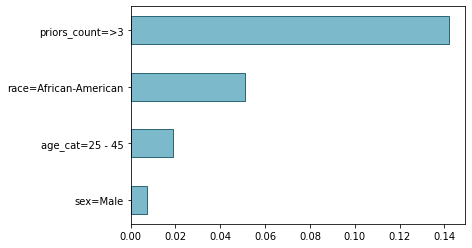

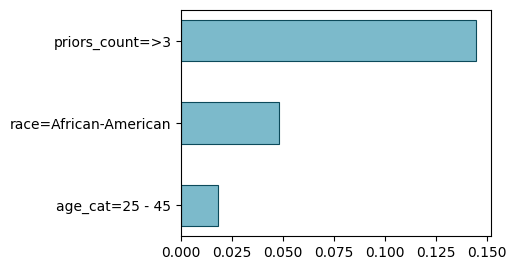

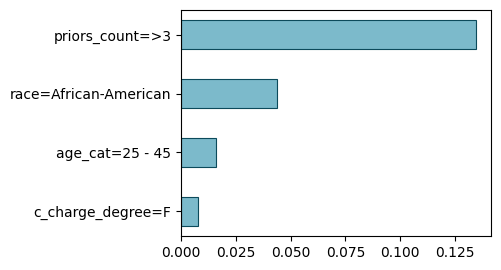

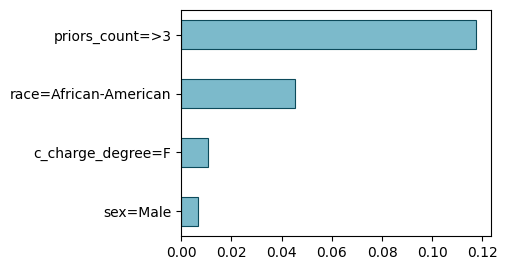

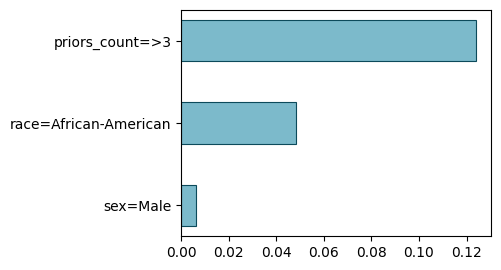

In [25]:
topK_ofI=fp_divergence_ofI.getDivergenceTopK(K=5, th_redundancy=0)
for item in topK_ofI.keys():
    fp_divergence_ofI.plotShapleyValue(item)

{frozenset({'priors_count=>3', 'race=African-American', 'sex=Male', 'age_cat=25 - 45'}): 0.21972170893335036}
{frozenset({'priors_count=>3'}): 0.14226087371897317, frozenset({'race=African-American'}): 0.05115538154975479, frozenset({'sex=Male'}): 0.007220590601649036, frozenset({'age_cat=25 - 45'}): 0.019084863062973356}


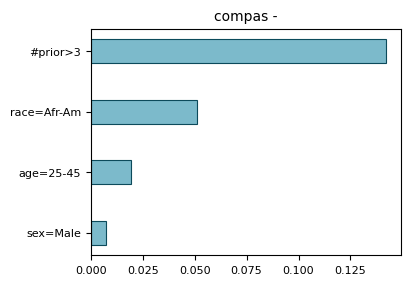

In [26]:
outputName=f"{outDirShap}/{dataset_name}_shap_{fp_divergence_ofI.metric_name}_{min_sup}"
itemset_div=fp_divergence_ofI.getDivergenceTopK(K=1, th_redundancy=0)
print(itemset_div)
itemset_shap=fp_divergence_ofI.computeShapleyValue(list(itemset_div.keys())[0])
print(itemset_shap)
fp_divergence_ofI.plotShapleyValue(shapley_values=itemset_shap, abbreviations=abbreviations,\
                 height=0.4,\
                 title=f"{dataset_name} -", sizeFig=(1.3,1.2), labelsize=8, saveFig=saveFig, nameFig=outputName)

#### Lattice Explorer

In [27]:
top1=list(fp_divergence_ofI.getDivergenceTopK(K=1, th_redundancy=0).keys())[0]
fig1=fp_divergence_ofI.plotLatticeItemset(top1, Th_divergence=0.15, sizeDot="small", getLower=True)

### Corrective

Given an itemset $I$ and an item $i \not\in I$, we say that $i$ is a *corrective item* for $I$ if 
$|\Delta(I \cup i)|<|\Delta(I)|$.


The *corrective factor* of $i$ w.r.t.\ $I$ is 
$|\Delta(I)| - |\Delta(I \cup i)|$.

In [28]:
#Significant corrective items based on t-value of difference
corrSign=fp_divergence_ofI.getCorrectiveItems()
corrSign.head(5)

,item i,S,S+i,v_i,v_S,v_S+i,t_value_corr,t_value_S+i,corr_factor
289,(priors_count=0),"(race=African-American, sex=Male)","(priors_count=0, race=African-American, sex=Male)",-0.039927,0.062371,0.009430,2.823776,0.711601,0.052941
97,(priors_count=0),(race=African-American),"(race=African-American, priors_count=0)",-0.039927,0.051052,-0.000500,3.376132,0.055937,0.050552
259,(race=African-American),"(length_of_stay=<week, priors_count=0)","(race=African-American, length_of_stay=<week, priors_count=0)",0.051052,-0.043788,-0.003043,3.070673,0.126799,0.040746
96,(race=African-American),(priors_count=0),"(race=African-American, priors_count=0)",0.051052,-0.039927,-0.000500,3.035485,0.055937,0.039427
375,"(priors_count=[1,3])","(race=African-American, length_of_stay=<week, sex=Male)","(priors_count=[1,3], race=African-American, length_of_stay=<week, sex=Male)",-0.015258,0.037486,-0.001609,2.005249,0.032579,0.035877


Only itemsets with positive divergence

In [29]:
corrSign_pos=fp_divergence_ofI.getCorrectiveItemsPos()
corrSign_pos.head()

,item i,S,S+i,v_i,v_S,v_S+i,t_value_corr,t_value_S+i,corr_factor
289,(priors_count=0),"(race=African-American, sex=Male)","(priors_count=0, race=African-American, sex=Male)",-0.039927,0.062371,0.009430,2.823776,0.711601,0.052941
97,(priors_count=0),(race=African-American),"(race=African-American, priors_count=0)",-0.039927,0.051052,-0.000500,3.376132,0.055937,0.050552
375,"(priors_count=[1,3])","(race=African-American, length_of_stay=<week, sex=Male)","(priors_count=[1,3], race=African-American, length_of_stay=<week, sex=Male)",-0.015258,0.037486,-0.001609,2.005249,0.032579,0.035877
261,(priors_count=0),"(race=African-American, length_of_stay=<week)","(race=African-American, length_of_stay=<week, priors_count=0)",-0.039927,0.029713,-0.003043,2.063030,0.126799,0.026671
217,(priors_count=0),"(c_charge_degree=F, sex=Male)","(priors_count=0, c_charge_degree=F, sex=Male)",-0.039927,0.022727,-0.020632,3.244110,1.688078,0.002095


Details of $S$ and $S \cup i$ for the top corrective items

In [30]:
d=fp_divergence_ofI.getCorrectiveItems()
itemsetsOfI=d[["S", "S+i"]].head(4).values
for S,S_i in itemsetsOfI:
    display(fp_divergence_ofI.getInfoItemsets([S,S_i])[INFOS])

,support,itemsets,tn,tp,fn,fp,d_fpr,fpr,t_value_fp
11,0.425470,"(race=African-American, sex=Male)",992,571,887,176,0.062371,0.150685,5.426049
144,0.103046,"(priors_count=0, race=African-American, sex=Male)",360,53,184,39,0.009430,0.097744,0.711601


,support,itemsets,tn,tp,fn,fp,d_fpr,fpr,t_value_fp
7,0.514420,(race=African-American),1303,634,1027,211,0.051052,0.139366,5.046409
100,0.137071,"(race=African-American, priors_count=0)",509,61,227,49,-0.000500,0.087814,0.055937


,support,itemsets,tn,tp,fn,fp,d_fpr,fpr,t_value_fp
23,0.303143,"(length_of_stay=<week, priors_count=0)",1309,67,434,61,-0.043788,0.044526,5.826463
121,0.122975,"(race=African-American, length_of_stay=<week, priors_count=0)",472,42,201,44,-0.003043,0.085271,0.126799


,support,itemsets,tn,tp,fn,fp,d_fpr,fpr,t_value_fp
20,0.337816,(priors_count=0),1416,99,498,72,-0.039927,0.048387,5.323913
100,0.137071,"(race=African-American, priors_count=0)",509,61,227,49,-0.000500,0.087814,0.055937


#### Plot Shapley comparison corrective

In [31]:
from divexplorer.shapley_value_FPx import plotComparisonShapleyValues, compareShapleyValues, normalizeMax

,support,itemsets,tn,tp,fn,fp,d_fpr,fpr,t_value_fp
11,0.425470,"(race=African-American, sex=Male)",992,571,887,176,0.062371,0.150685,5.426049
144,0.103046,"(priors_count=0, race=African-American, sex=Male)",360,53,184,39,0.009430,0.097744,0.711601


∇FPR(S):0.062 -->  ∇FPR(S U i):0.009


/home/eliana/Projects/DivExplorerG/divexplorer/divexplorer/shapley_value_FPx.py:412: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 



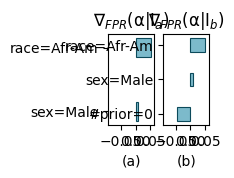

In [32]:
id_col=0
fp_divergence_ofI=fp_divergence_ofI
corrSign=fp_divergence_ofI.getCorrectiveItems()

if len(corrSign)>id_col:
    outputName=f"{outDirShap}/{dataset_name}_shap_corrective_{fp_divergence_ofI.metric_name}_{min_sup}"
    S,S_i, v_S, v_Si=corrSign[["S", "S+i", "v_S", "v_S+i"]].head(id_col+1).values[id_col].tolist()
    display(fp_divergence_ofI.getInfoItemsets([S,S_i])[INFOS])
    shap_itemset1=abbreviateDict(fp_divergence_ofI.computeShapleyValue(S), abbreviations)
    shap_itemset2=abbreviateDict(fp_divergence_ofI.computeShapleyValue(S_i), abbreviations)
    id1, id2="$_a$", "$_b$" 
    t1, t2=f"$∇_{{{fp_divergence_ofI.metric_name}}}$(α|I{id1})", f"$∇_{{{fp_divergence_ofI.metric_name}}}$(α|I{id2})"
    print(f"∇{fp_divergence_ofI.metric_name}(S):{round(v_S,3)} -->  ∇{fp_divergence_ofI.metric_name}(S U i):{round(v_Si,3)}")

    plotComparisonShapleyValues(shap_itemset1, shap_itemset2, height=[0.3, 0.4], sharedAxis=True, \
                        sizeFig=(5.2, 1.9), title=[t1,t2], saveFig=saveFig, nameFig=outputName, pad=1.5,\
                               metrics_name=[fp_divergence_ofI.metric_name, fp_divergence_ofI.metric_name])

#### Lattice

In [33]:
id_col=0
fp_divergence_ofI=fp_divergence_ofI
corrSign=fp_divergence_ofI.getCorrectiveItems()
if len(corrSign)>id_col:
    S_i=corrSign[["S+i"]].head(id_col+1).values[id_col][0]
    print(S_i)
    fig1=fp_divergence_ofI.plotLatticeItemset(S_i, Th_divergence=0.15, sizeDot="small", getLower=True)
    if saveFig:
        fig1.write_image(f"{outDirLattice}/lattice_corrective_{dataset_name}_{fp_divergence_ofI.metric_name}_{min_sup}.pdf")

frozenset({'priors_count=0', 'race=African-American', 'sex=Male'})


In [34]:
#selectItemsInteractive(fp_divergence_ofI)

## False negative rate

In [35]:
fp_divergence_ofI=FP_Divergence(FP_fm, "d_fnr")

In [36]:
INFOS=ITEMSETS+[fp_divergence_ofI.metric, fp_divergence_ofI.metric_name.lower(), fp_divergence_ofI.t_value_col]

In [37]:
fp_divergence_ofI.getInfoItemset(frozenset())[INFOS]

,support,itemsets,tn,tp,fn,fp,d_fnr,fnr,t_value_fn
0,1.0,(),3066,847,1962,297,0.0,0.698469,0.0


### Top K

In [38]:
fp_divergence_ofI.getDivergence(th_redundancy=0)[INFOS].head(10)

,support,itemsets,tn,tp,fn,fp,d_fnr,fnr,t_value_fn
88,0.148250,"(length_of_stay=<week, priors_count=0, age_cat=25 - 45)",675,14,201,25,0.236415,0.934884,12.088217
146,0.102398,"(priors_count=[1,3], length_of_stay=<week, c_charge_degree=M)",380,16,219,17,0.233446,0.931915,12.209479
147,0.101750,"(race=Caucasian, age_cat=Greater than 45)",452,12,158,6,0.230943,0.929412,10.332685
142,0.107097,"(priors_count=0, length_of_stay=<week, sex=Male, age_cat=25 - 45)",479,12,152,18,0.228360,0.926829,9.918399
128,0.119086,"(length_of_stay=<week, c_charge_degree=M, race=Caucasian)",504,16,201,14,0.227798,0.926267,11.197136
116,0.127025,"(length_of_stay=<week, sex=Male, age_cat=Greater than 45)",549,19,202,14,0.215558,0.914027,10.113018
76,0.158782,"(length_of_stay=<week, age_cat=Greater than 45)",706,23,237,14,0.213069,0.911538,10.619408
90,0.146630,"(length_of_stay=<week, priors_count=0, c_charge_degree=M)",675,19,189,22,0.210185,0.908654,9.390201
124,0.122165,"(priors_count=[1,3], length_of_stay=<week, sex=Male, age_cat=25 - 45)",433,28,271,22,0.207885,0.906355,10.773803
152,0.101102,"(priors_count=0, length_of_stay=<week, sex=Male, c_charge_degree=M)",451,15,144,14,0.207191,0.905660,8.076216


Top FPR - Only divergence info

In [39]:
fp_divergence_ofI.getDivergence(th_redundancy=0)[["support", "itemsets",  fp_divergence_ofI.metric, fp_divergence_ofI.t_value_col]].head(5)

,support,itemsets,d_fnr,t_value_fn
88,0.148250,"(length_of_stay=<week, priors_count=0, age_cat=25 - 45)",0.236415,12.088217
146,0.102398,"(priors_count=[1,3], length_of_stay=<week, c_charge_degree=M)",0.233446,12.209479
147,0.101750,"(race=Caucasian, age_cat=Greater than 45)",0.230943,10.332685
142,0.107097,"(priors_count=0, length_of_stay=<week, sex=Male, age_cat=25 - 45)",0.228360,9.918399
128,0.119086,"(length_of_stay=<week, c_charge_degree=M, race=Caucasian)",0.227798,11.197136


Threshold on redundancy

In [40]:
fp_divergence_ofI.getDivergence(th_redundancy=0)[["support", "itemsets",  fp_divergence_ofI.metric, fp_divergence_ofI.t_value_col]].head(5)

,support,itemsets,d_fnr,t_value_fn
88,0.148250,"(length_of_stay=<week, priors_count=0, age_cat=25 - 45)",0.236415,12.088217
146,0.102398,"(priors_count=[1,3], length_of_stay=<week, c_charge_degree=M)",0.233446,12.209479
147,0.101750,"(race=Caucasian, age_cat=Greater than 45)",0.230943,10.332685
142,0.107097,"(priors_count=0, length_of_stay=<week, sex=Male, age_cat=25 - 45)",0.228360,9.918399
128,0.119086,"(length_of_stay=<week, c_charge_degree=M, race=Caucasian)",0.227798,11.197136


Printable - threshold on redundancy

In [41]:
th_redundancy=0.01
div_ofI=fp_divergence_ofI.getDivergence(th_redundancy=th_redundancy)[["support", "itemsets",  fp_divergence_ofI.metric, fp_divergence_ofI.t_value_col]]
print(f"{dataset_name} - #FP: {len(div_ofI)-1} - {fp_divergence_ofI.metric_name} - th_redundancy: {th_redundancy}")
display(div_ofI.head(5))

compas - #FP: 108 - FNR - th_redundancy: 0.01


,support,itemsets,d_fnr,t_value_fn
88,0.148250,"(length_of_stay=<week, priors_count=0, age_cat=25 - 45)",0.236415,12.088217
146,0.102398,"(priors_count=[1,3], length_of_stay=<week, c_charge_degree=M)",0.233446,12.209479
147,0.101750,"(race=Caucasian, age_cat=Greater than 45)",0.230943,10.332685
128,0.119086,"(length_of_stay=<week, c_charge_degree=M, race=Caucasian)",0.227798,11.197136
76,0.158782,"(length_of_stay=<week, age_cat=Greater than 45)",0.213069,10.619408


In [42]:
fp_divergence_ofI.getDivergenceTopKDf(K=10, th_redundancy=0)

,itemsets,d_fnr
88,"(length_of_stay=<week, priors_count=0, age_cat=25 - 45)",0.236415
146,"(priors_count=[1,3], length_of_stay=<week, c_charge_degree=M)",0.233446
147,"(race=Caucasian, age_cat=Greater than 45)",0.230943
142,"(priors_count=0, length_of_stay=<week, sex=Male, age_cat=25 - 45)",0.228360
128,"(length_of_stay=<week, c_charge_degree=M, race=Caucasian)",0.227798
116,"(length_of_stay=<week, sex=Male, age_cat=Greater than 45)",0.215558
76,"(length_of_stay=<week, age_cat=Greater than 45)",0.213069
90,"(length_of_stay=<week, priors_count=0, c_charge_degree=M)",0.210185
124,"(priors_count=[1,3], length_of_stay=<week, sex=Male, age_cat=25 - 45)",0.207885
152,"(priors_count=0, length_of_stay=<week, sex=Male, c_charge_degree=M)",0.207191


### Shapley value of TOP-K patterns

In [43]:
topK_ofI=fp_divergence_ofI.getDivergenceTopK(K=5, th_redundancy=0)
topK_ofI

{frozenset({'age_cat=25 - 45',
            'length_of_stay=<week',
            'priors_count=0'}): 0.236414514807057,
 frozenset({'c_charge_degree=M',
            'length_of_stay=<week',
            'priors_count=[1,3]'}): 0.23344568749384575,
 frozenset({'age_cat=Greater than 45', 'race=Caucasian'}): 0.23094255858270685,
 frozenset({'age_cat=25 - 45',
            'length_of_stay=<week',
            'priors_count=0',
            'sex=Male'}): 0.22836006216950744,
 frozenset({'c_charge_degree=M',
            'length_of_stay=<week',
            'race=Caucasian'}): 0.22779807498281524}

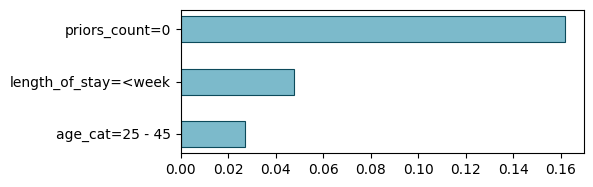

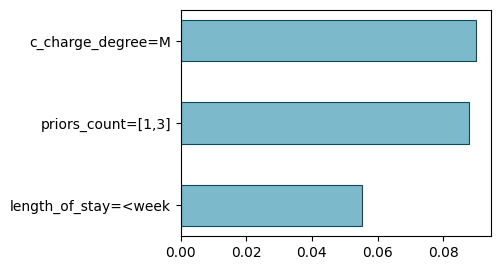

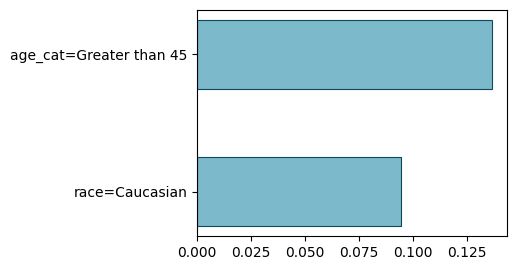

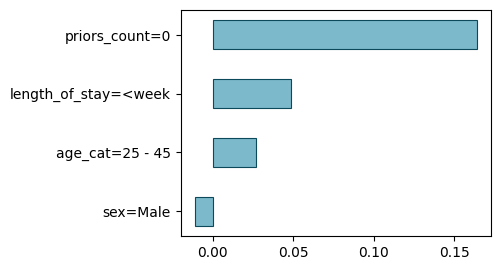

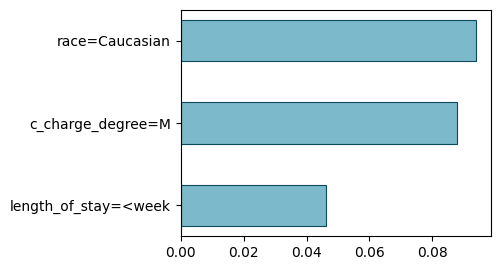

In [44]:
topK_ofI=fp_divergence_ofI.getDivergenceTopK(K=5, th_redundancy=0)
for item in topK_ofI.keys():
    fp_divergence_ofI.plotShapleyValue(item)

{frozenset({'length_of_stay=<week', 'priors_count=0', 'age_cat=25 - 45'}): 0.236414514807057}
{frozenset({'length_of_stay=<week'}): 0.04758824588792979, frozenset({'priors_count=0'}): 0.16162845032199327, frozenset({'age_cat=25 - 45'}): 0.027197818597133917}


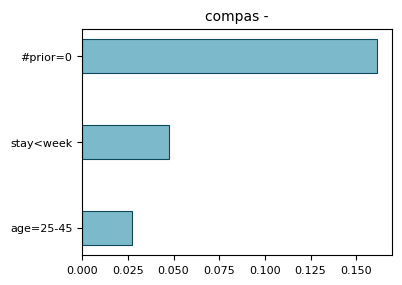

In [45]:
outputName=f"{outDirShap}/{dataset_name}_shap_{fp_divergence_ofI.metric_name}_{min_sup}"
itemset_div=fp_divergence_ofI.getDivergenceTopK(K=1, th_redundancy=0)
print(itemset_div)
itemset_shap=fp_divergence_ofI.computeShapleyValue(list(itemset_div.keys())[0])
print(itemset_shap)
fp_divergence_ofI.plotShapleyValue(shapley_values=itemset_shap, abbreviations=abbreviations,\
                 height=0.4,\
                 title=f"{dataset_name} -", sizeFig=(1.3,1.2), labelsize=8, saveFig=saveFig, nameFig=outputName)

#### Lattice Explorer

In [46]:
top1=list(fp_divergence_ofI.getDivergenceTopK(K=1, th_redundancy=0).keys())[0]
fig1=fp_divergence_ofI.plotLatticeItemset(top1, Th_divergence=0.15, sizeDot="small", getLower=True)

### Corrective

Given an itemset $I$ and an item $i \not\in I$, we say that $i$ is a *corrective item* for $I$ if 
$|\Delta(I \cup i)|<|\Delta(I)|$.


The *corrective factor* of $i$ w.r.t.\ $I$ is 
$|\Delta(I)| - |\Delta(I \cup i)|$.

In [47]:
#Significant corrective items based on t-value of difference
corrSign=fp_divergence_ofI.getCorrectiveItems()
corrSign.head(5)

,item i,S,S+i,v_i,v_S,v_S+i,t_value_corr,t_value_S+i,corr_factor
399,"(priors_count=[1,3])","(race=African-American, c_charge_degree=F, sex=Male)","(priors_count=[1,3], race=African-American, c_charge_degree=F, sex=Male)",0.093156,-0.122627,-0.010782,3.761896,0.439716,0.111845
256,"(priors_count=[1,3])","(race=African-American, c_charge_degree=F)","(priors_count=[1,3], race=African-American, c_charge_degree=F)",0.093156,-0.112602,0.004095,4.281193,0.129915,0.108507
249,(c_charge_degree=M),"(race=African-American, sex=Male)","(race=African-American, sex=Male, c_charge_degree=M)",0.095470,-0.090102,-0.001033,3.331496,0.076725,0.089068
84,(race=African-American),(c_charge_degree=M),"(race=African-American, c_charge_degree=M)",-0.080167,0.095470,0.008738,3.378966,0.342429,0.086732
247,(race=African-American),"(sex=Male, c_charge_degree=M)","(race=African-American, sex=Male, c_charge_degree=M)",-0.080167,0.084265,-0.001033,3.056766,0.076725,0.083231


Only itemsets with positive divergence

In [48]:
corrSign_pos=fp_divergence_ofI.getCorrectiveItemsPos()
corrSign_pos.head()

,item i,S,S+i,v_i,v_S,v_S+i,t_value_corr,t_value_S+i,corr_factor
84,(race=African-American),(c_charge_degree=M),"(race=African-American, c_charge_degree=M)",-0.080167,0.095470,0.008738,3.378966,0.342429,0.086732
247,(race=African-American),"(sex=Male, c_charge_degree=M)","(race=African-American, sex=Male, c_charge_degree=M)",-0.080167,0.084265,-0.001033,3.056766,0.076725,0.083231
244,(race=African-American),"(length_of_stay=<week, c_charge_degree=M)","(race=African-American, length_of_stay=<week, c_charge_degree=M)",-0.080167,0.143802,0.065881,2.861090,2.594676,0.077921
391,(race=African-American),"(length_of_stay=<week, sex=Male, c_charge_degree=M)","(race=African-American, length_of_stay=<week, sex=Male, c_charge_degree=M)",-0.080167,0.129833,0.053279,2.544816,1.920765,0.076554
376,(race=African-American),"(priors_count=[1,3], length_of_stay=<week, sex=Male)","(priors_count=[1,3], race=African-American, length_of_stay=<week, sex=Male)",-0.080167,0.138231,0.071228,2.440267,2.824180,0.067003


Details of $S$ and $S \cup i$ for the top corrective items

In [49]:
d=fp_divergence_ofI.getCorrectiveItems()
itemsetsOfI=d[["S", "S+i"]].head(4).values
for S,S_i in itemsetsOfI:
    display(fp_divergence_ofI.getInfoItemsets([S,S_i])[INFOS])

,support,itemsets,tn,tp,fn,fp,d_fnr,fnr,t_value_fn
27,0.297472,"(race=African-American, c_charge_degree=F, sex=Male)",641,453,615,127,-0.122627,0.575843,7.044825
153,0.100454,"(priors_count=[1,3], race=African-American, c_charge_degree=F, sex=Male)",249,104,229,38,-0.010782,0.687688,0.439716


,support,itemsets,tn,tp,fn,fp,d_fnr,fnr,t_value_fn
17,0.355800,"(race=African-American, c_charge_degree=F)",826,504,713,153,-0.112602,0.585867,6.804881
119,0.123785,"(priors_count=[1,3], race=African-American, c_charge_degree=F)",327,116,274,47,0.004095,0.702564,0.129915


,support,itemsets,tn,tp,fn,fp,d_fnr,fnr,t_value_fn
11,0.425470,"(race=African-American, sex=Male)",992,571,887,176,-0.090102,0.608368,5.840685
114,0.127997,"(race=African-American, sex=Male, c_charge_degree=M)",351,118,272,49,-0.001033,0.697436,0.076725


,support,itemsets,tn,tp,fn,fp,d_fnr,fnr,t_value_fn
16,0.356773,(c_charge_degree=M),1294,170,655,83,0.095470,0.793939,5.743590
77,0.158620,"(race=African-American, c_charge_degree=M)",477,130,314,58,0.008738,0.707207,0.342429


#### Plot Shapley comparison corrective

In [50]:
from divexplorer.shapley_value_FPx import plotComparisonShapleyValues, compareShapleyValues, normalizeMax

,support,itemsets,tn,tp,fn,fp,d_fnr,fnr,t_value_fn
27,0.297472,"(race=African-American, c_charge_degree=F, sex=Male)",641,453,615,127,-0.122627,0.575843,7.044825
153,0.100454,"(priors_count=[1,3], race=African-American, c_charge_degree=F, sex=Male)",249,104,229,38,-0.010782,0.687688,0.439716


∇FNR(S):-0.123 -->  ∇FNR(S U i):-0.011


/home/eliana/Projects/DivExplorerG/divexplorer/divexplorer/shapley_value_FPx.py:412: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 



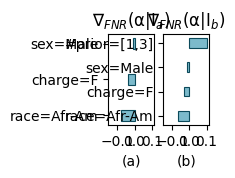

In [51]:
id_col=0
fp_divergence_ofI=fp_divergence_ofI
corrSign=fp_divergence_ofI.getCorrectiveItems()

if len(corrSign)>id_col:
    outputName=f"{outDirShap}/{dataset_name}_shap_corrective_{fp_divergence_ofI.metric_name}_{min_sup}"
    S,S_i, v_S, v_Si=corrSign[["S", "S+i", "v_S", "v_S+i"]].head(id_col+1).values[id_col].tolist()
    display(fp_divergence_ofI.getInfoItemsets([S,S_i])[INFOS])
    shap_itemset1=abbreviateDict(fp_divergence_ofI.computeShapleyValue(S), abbreviations)
    shap_itemset2=abbreviateDict(fp_divergence_ofI.computeShapleyValue(S_i), abbreviations)
    id1, id2="$_a$", "$_b$" 
    t1, t2=f"$∇_{{{fp_divergence_ofI.metric_name}}}$(α|I{id1})", f"$∇_{{{fp_divergence_ofI.metric_name}}}$(α|I{id2})"
    print(f"∇{fp_divergence_ofI.metric_name}(S):{round(v_S,3)} -->  ∇{fp_divergence_ofI.metric_name}(S U i):{round(v_Si,3)}")

    plotComparisonShapleyValues(shap_itemset1, shap_itemset2, height=[0.3, 0.4], sharedAxis=True, \
                        sizeFig=(5.2, 1.9), title=[t1,t2], saveFig=saveFig, nameFig=outputName, pad=1.5,\
                               metrics_name=[fp_divergence_ofI.metric_name, fp_divergence_ofI.metric_name])

#### Lattice

In [52]:
id_col=0
fp_divergence_ofI=fp_divergence_ofI
corrSign=fp_divergence_ofI.getCorrectiveItems()
if len(corrSign)>id_col:
    S_i=corrSign[["S+i"]].head(id_col+1).values[id_col][0]
    print(S_i)
    fig1=fp_divergence_ofI.plotLatticeItemset(S_i, Th_divergence=0.15, sizeDot="small", getLower=True)
    if saveFig:
        fig1.write_image(f"{outDirLattice}/lattice_corrective_{dataset_name}_{fp_divergence_ofI.metric_name}_{min_sup}.pdf")

frozenset({'priors_count=[1,3]', 'race=African-American', 'c_charge_degree=F', 'sex=Male'})


## Accuracy

In [53]:
fp_divergence_ofI=FP_Divergence(FP_fm, "d_accuracy")

In [54]:
INFOS=ITEMSETS+[fp_divergence_ofI.metric, fp_divergence_ofI.metric_name.lower(), fp_divergence_ofI.t_value_col]

In [55]:
fp_divergence_ofI.getInfoItemset(frozenset())[INFOS]

,support,itemsets,tn,tp,fn,fp,d_accuracy,accuracy,t_value_tp_tn
0,1.0,(),3066,847,1962,297,0.0,0.633992,0.0


### Top K

In [56]:
fp_divergence_ofI.getDivergence(th_redundancy=0)[INFOS].head(10)

,support,itemsets,tn,tp,fn,fp,d_accuracy,accuracy,t_value_tp_tn
129,0.118600,"(length_of_stay=<week, priors_count=0, race=Caucasian)",547,20,153,12,0.140598,0.774590,8.425313
90,0.146630,"(length_of_stay=<week, priors_count=0, c_charge_degree=M)",675,19,189,22,0.132859,0.766851,8.634280
83,0.155541,"(priors_count=0, c_charge_degree=M)",703,29,205,23,0.128508,0.762500,8.516132
106,0.133020,"(priors_count=0, race=Caucasian)",594,32,179,16,0.128493,0.762485,7.966142
88,0.148250,"(length_of_stay=<week, priors_count=0, age_cat=25 - 45)",675,14,201,25,0.119013,0.753005,7.641727
73,0.166235,"(priors_count=0, age_cat=25 - 45)",737,30,230,29,0.113571,0.747563,7.606603
152,0.101102,"(priors_count=0, length_of_stay=<week, sex=Male, c_charge_degree=M)",451,15,144,14,0.112803,0.746795,6.079120
76,0.158782,"(length_of_stay=<week, age_cat=Greater than 45)",706,23,237,14,0.109885,0.743878,7.190067
142,0.107097,"(priors_count=0, length_of_stay=<week, sex=Male, age_cat=25 - 45)",479,12,152,18,0.108822,0.742814,5.990493
138,0.108231,"(priors_count=0, sex=Male, c_charge_degree=M)",471,25,157,15,0.108523,0.742515,6.000220


Top FPR - Only divergence info

In [57]:
fp_divergence_ofI.getDivergence(th_redundancy=0)[["support", "itemsets",  fp_divergence_ofI.metric, fp_divergence_ofI.t_value_col]].head(5)

,support,itemsets,d_accuracy,t_value_tp_tn
129,0.118600,"(length_of_stay=<week, priors_count=0, race=Caucasian)",0.140598,8.425313
90,0.146630,"(length_of_stay=<week, priors_count=0, c_charge_degree=M)",0.132859,8.634280
83,0.155541,"(priors_count=0, c_charge_degree=M)",0.128508,8.516132
106,0.133020,"(priors_count=0, race=Caucasian)",0.128493,7.966142
88,0.148250,"(length_of_stay=<week, priors_count=0, age_cat=25 - 45)",0.119013,7.641727


Threshold on redundancy

In [58]:
fp_divergence_ofI.getDivergence(th_redundancy=0)[["support", "itemsets",  fp_divergence_ofI.metric, fp_divergence_ofI.t_value_col]].head(5)

,support,itemsets,d_accuracy,t_value_tp_tn
129,0.118600,"(length_of_stay=<week, priors_count=0, race=Caucasian)",0.140598,8.425313
90,0.146630,"(length_of_stay=<week, priors_count=0, c_charge_degree=M)",0.132859,8.634280
83,0.155541,"(priors_count=0, c_charge_degree=M)",0.128508,8.516132
106,0.133020,"(priors_count=0, race=Caucasian)",0.128493,7.966142
88,0.148250,"(length_of_stay=<week, priors_count=0, age_cat=25 - 45)",0.119013,7.641727


Printable - threshold on redundancy

In [59]:
th_redundancy=0.01
div_ofI=fp_divergence_ofI.getDivergence(th_redundancy=th_redundancy)[["support", "itemsets",  fp_divergence_ofI.metric, fp_divergence_ofI.t_value_col]]
print(f"{dataset_name} - #FP: {len(div_ofI)-1} - {fp_divergence_ofI.metric_name} - th_redundancy: {th_redundancy}")
display(div_ofI.head(5))

compas - #FP: 57 - ACCURACY - th_redundancy: 0.01


,support,itemsets,d_accuracy,t_value_tp_tn
129,0.118600,"(length_of_stay=<week, priors_count=0, race=Caucasian)",0.140598,8.425313
83,0.155541,"(priors_count=0, c_charge_degree=M)",0.128508,8.516132
106,0.133020,"(priors_count=0, race=Caucasian)",0.128493,7.966142
73,0.166235,"(priors_count=0, age_cat=25 - 45)",0.113571,7.606603
76,0.158782,"(length_of_stay=<week, age_cat=Greater than 45)",0.109885,7.190067


In [60]:
fp_divergence_ofI.getDivergenceTopKDf(K=10, th_redundancy=0)

,itemsets,d_accuracy
129,"(length_of_stay=<week, priors_count=0, race=Caucasian)",0.140598
90,"(length_of_stay=<week, priors_count=0, c_charge_degree=M)",0.132859
83,"(priors_count=0, c_charge_degree=M)",0.128508
106,"(priors_count=0, race=Caucasian)",0.128493
88,"(length_of_stay=<week, priors_count=0, age_cat=25 - 45)",0.119013
73,"(priors_count=0, age_cat=25 - 45)",0.113571
152,"(priors_count=0, length_of_stay=<week, sex=Male, c_charge_degree=M)",0.112803
76,"(length_of_stay=<week, age_cat=Greater than 45)",0.109885
142,"(priors_count=0, length_of_stay=<week, sex=Male, age_cat=25 - 45)",0.108822
138,"(priors_count=0, sex=Male, c_charge_degree=M)",0.108523


### Shapley value of TOP-K patterns

In [61]:
topK_ofI=fp_divergence_ofI.getDivergenceTopK(K=5, th_redundancy=0)
topK_ofI

{frozenset({'length_of_stay=<week',
            'priors_count=0',
            'race=Caucasian'}): 0.1405979409921061,
 frozenset({'c_charge_degree=M',
            'length_of_stay=<week',
            'priors_count=0'}): 0.13285860578696163,
 frozenset({'c_charge_degree=M', 'priors_count=0'}): 0.1285077770576798,
 frozenset({'priors_count=0', 'race=Caucasian'}): 0.12849255172272245,
 frozenset({'age_cat=25 - 45',
            'length_of_stay=<week',
            'priors_count=0'}): 0.1190132415385542}

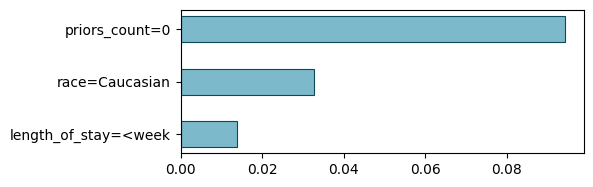

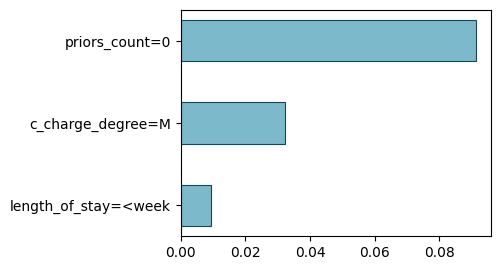

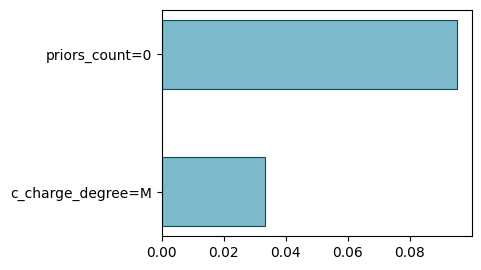

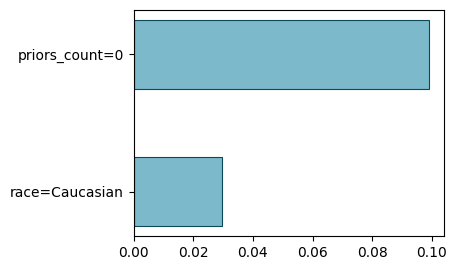

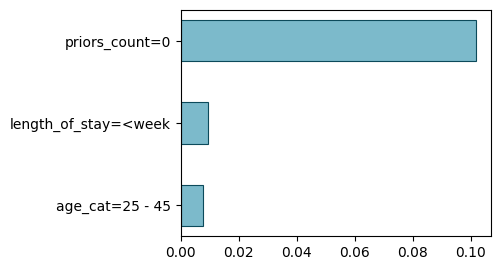

In [62]:
topK_ofI=fp_divergence_ofI.getDivergenceTopK(K=5, th_redundancy=0)
for item in topK_ofI.keys():
    fp_divergence_ofI.plotShapleyValue(item)

{frozenset({'length_of_stay=<week', 'priors_count=0', 'race=Caucasian'}): 0.1405979409921061}
{frozenset({'length_of_stay=<week'}): 0.013688858066902398, frozenset({'priors_count=0'}): 0.09414110860147784, frozenset({'race=Caucasian'}): 0.03276797432372586}


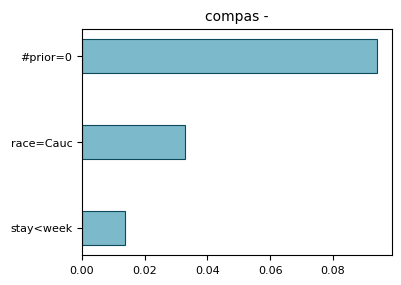

In [63]:
outputName=f"{outDirShap}/{dataset_name}_shap_{fp_divergence_ofI.metric_name}_{min_sup}"
itemset_div=fp_divergence_ofI.getDivergenceTopK(K=1, th_redundancy=0)
print(itemset_div)
itemset_shap=fp_divergence_ofI.computeShapleyValue(list(itemset_div.keys())[0])
print(itemset_shap)
fp_divergence_ofI.plotShapleyValue(shapley_values=itemset_shap, abbreviations=abbreviations,\
                 height=0.4,\
                 title=f"{dataset_name} -", sizeFig=(1.3,1.2), labelsize=8, saveFig=saveFig, nameFig=outputName)

#### Lattice Explorer

In [64]:
top1=list(fp_divergence_ofI.getDivergenceTopK(K=1, th_redundancy=0).keys())[0]
fig1=fp_divergence_ofI.plotLatticeItemset(top1, Th_divergence=0.15, sizeDot="small", getLower=True)

### Corrective

Given an itemset $I$ and an item $i \not\in I$, we say that $i$ is a *corrective item* for $I$ if 
$|\Delta(I \cup i)|<|\Delta(I)|$.


The *corrective factor* of $i$ w.r.t.\ $I$ is 
$|\Delta(I)| - |\Delta(I \cup i)|$.

In [65]:
#Significant corrective items based on t-value of difference
corrSign=fp_divergence_ofI.getCorrectiveItems()
corrSign.head(5)

,item i,S,S+i,v_i,v_S,v_S+i,t_value_corr,t_value_S+i,corr_factor
290,(race=African-American),"(priors_count=0, sex=Male)","(priors_count=0, race=African-American, sex=Male)",-0.023913,0.076534,0.015379,2.776289,0.753259,0.061155
259,(race=African-American),"(length_of_stay=<week, priors_count=0)","(race=African-American, length_of_stay=<week, priors_count=0)",-0.023913,0.101443,0.043215,2.955671,2.374896,0.058229
96,(race=African-American),(priors_count=0),"(race=African-American, priors_count=0)",-0.023913,0.092626,0.039767,2.818701,2.287583,0.052860
295,"(priors_count=[1,3])","(length_of_stay=<week, c_charge_degree=M)","(priors_count=[1,3], length_of_stay=<week, c_charge_degree=M)",-0.023711,0.044867,-0.007410,2.381362,0.385315,0.037457
244,(race=African-American),"(length_of_stay=<week, c_charge_degree=M)","(race=African-American, length_of_stay=<week, c_charge_degree=M)",-0.023913,0.044867,-0.009307,2.676936,0.525724,0.035560


Only itemsets with positive divergence

In [66]:
corrSign_pos=fp_divergence_ofI.getCorrectiveItemsPos()
corrSign_pos.head()

,item i,S,S+i,v_i,v_S,v_S+i,t_value_corr,t_value_S+i,corr_factor
290,(race=African-American),"(priors_count=0, sex=Male)","(priors_count=0, race=African-American, sex=Male)",-0.023913,0.076534,0.015379,2.776289,0.753259,0.061155
259,(race=African-American),"(length_of_stay=<week, priors_count=0)","(race=African-American, length_of_stay=<week, priors_count=0)",-0.023913,0.101443,0.043215,2.955671,2.374896,0.058229
96,(race=African-American),(priors_count=0),"(race=African-American, priors_count=0)",-0.023913,0.092626,0.039767,2.818701,2.287583,0.052860
295,"(priors_count=[1,3])","(length_of_stay=<week, c_charge_degree=M)","(priors_count=[1,3], length_of_stay=<week, c_charge_degree=M)",-0.023711,0.044867,-0.007410,2.381362,0.385315,0.037457
244,(race=African-American),"(length_of_stay=<week, c_charge_degree=M)","(race=African-American, length_of_stay=<week, c_charge_degree=M)",-0.023913,0.044867,-0.009307,2.676936,0.525724,0.035560


Details of $S$ and $S \cup i$ for the top corrective items

In [67]:
d=fp_divergence_ofI.getCorrectiveItems()
itemsetsOfI=d[["S", "S+i"]].head(4).values
for S,S_i in itemsetsOfI:
    display(fp_divergence_ofI.getInfoItemsets([S,S_i])[INFOS])

,support,itemsets,tn,tp,fn,fp,d_accuracy,accuracy,t_value_tp_tn
37,0.252430,"(priors_count=0, sex=Male)",1022,85,396,55,0.076534,0.710526,5.862642
144,0.103046,"(priors_count=0, race=African-American, sex=Male)",360,53,184,39,0.015379,0.649371,0.753259


,support,itemsets,tn,tp,fn,fp,d_accuracy,accuracy,t_value_tp_tn
23,0.303143,"(length_of_stay=<week, priors_count=0)",1309,67,434,61,0.101443,0.735436,8.511401
121,0.122975,"(race=African-American, length_of_stay=<week, priors_count=0)",472,42,201,44,0.043215,0.677207,2.374896


,support,itemsets,tn,tp,fn,fp,d_accuracy,accuracy,t_value_tp_tn
20,0.337816,(priors_count=0),1416,99,498,72,0.092626,0.726619,8.023810
100,0.137071,"(race=African-American, priors_count=0)",509,61,227,49,0.039767,0.673759,2.287583


,support,itemsets,tn,tp,fn,fp,d_accuracy,accuracy,t_value_tp_tn
24,0.301199,"(length_of_stay=<week, c_charge_degree=M)",1162,100,534,63,0.044867,0.678860,3.595357
146,0.102398,"(priors_count=[1,3], length_of_stay=<week, c_charge_degree=M)",380,16,219,17,-0.007410,0.626582,0.385315


#### Plot Shapley comparison corrective

In [68]:
from divexplorer.shapley_value_FPx import plotComparisonShapleyValues, compareShapleyValues, normalizeMax

,support,itemsets,tn,tp,fn,fp,d_accuracy,accuracy,t_value_tp_tn
37,0.252430,"(priors_count=0, sex=Male)",1022,85,396,55,0.076534,0.710526,5.862642
144,0.103046,"(priors_count=0, race=African-American, sex=Male)",360,53,184,39,0.015379,0.649371,0.753259


∇ACCURACY(S):0.077 -->  ∇ACCURACY(S U i):0.015


/home/eliana/Projects/DivExplorerG/divexplorer/divexplorer/shapley_value_FPx.py:412: UserWarning:

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations



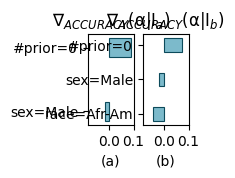

In [69]:
id_col=0
fp_divergence_ofI=fp_divergence_ofI
corrSign=fp_divergence_ofI.getCorrectiveItems()

if len(corrSign)>id_col:
    outputName=f"{outDirShap}/{dataset_name}_shap_corrective_{fp_divergence_ofI.metric_name}_{min_sup}"
    S,S_i, v_S, v_Si=corrSign[["S", "S+i", "v_S", "v_S+i"]].head(id_col+1).values[id_col].tolist()
    display(fp_divergence_ofI.getInfoItemsets([S,S_i])[INFOS])
    shap_itemset1=abbreviateDict(fp_divergence_ofI.computeShapleyValue(S), abbreviations)
    shap_itemset2=abbreviateDict(fp_divergence_ofI.computeShapleyValue(S_i), abbreviations)
    id1, id2="$_a$", "$_b$" 
    t1, t2=f"$∇_{{{fp_divergence_ofI.metric_name}}}$(α|I{id1})", f"$∇_{{{fp_divergence_ofI.metric_name}}}$(α|I{id2})"
    print(f"∇{fp_divergence_ofI.metric_name}(S):{round(v_S,3)} -->  ∇{fp_divergence_ofI.metric_name}(S U i):{round(v_Si,3)}")

    plotComparisonShapleyValues(shap_itemset1, shap_itemset2, height=[0.3, 0.4], sharedAxis=True, \
                        sizeFig=(5.2, 1.9), title=[t1,t2], saveFig=saveFig, nameFig=outputName, pad=1.5,\
                               metrics_name=[fp_divergence_ofI.metric_name, fp_divergence_ofI.metric_name])

#### Lattice

In [70]:
id_col=0
fp_divergence_ofI=fp_divergence_ofI
corrSign=fp_divergence_ofI.getCorrectiveItems()
if len(corrSign)>id_col:
    S_i=corrSign[["S+i"]].head(id_col+1).values[id_col][0]
    print(S_i)
    fig1=fp_divergence_ofI.plotLatticeItemset(S_i, Th_divergence=0.15, sizeDot="small", getLower=True)
    if saveFig:
        fig1.write_image(f"{outDirLattice}/lattice_corrective_{dataset_name}_{fp_divergence_ofI.metric_name}_{min_sup}.pdf")

frozenset({'priors_count=0', 'race=African-American', 'sex=Male'})


## Classification error

In [71]:
fp_divergence_ofI=FP_Divergence(FP_fm, "d_error")

In [72]:
INFOS=ITEMSETS+[fp_divergence_ofI.metric, fp_divergence_ofI.metric_name.lower(), fp_divergence_ofI.t_value_col]

In [73]:
fp_divergence_ofI.getInfoItemset(frozenset())[INFOS]

,support,itemsets,tn,tp,fn,fp,d_error,error,t_value_fp_fn
0,1.0,(),3066,847,1962,297,0.0,0.366008,0.0


### Top K

In [74]:
fp_divergence_ofI.getDivergence(th_redundancy=0)[INFOS].head(10)

,support,itemsets,tn,tp,fn,fp,d_error,error,t_value_fp_fn
151,0.101264,"(age_cat=Less than 25, race=African-American, length_of_stay=<week)",218,117,242,48,0.097992,0.464000,4.709274
104,0.134964,"(age_cat=Less than 25, length_of_stay=<week, sex=Male)",304,145,327,57,0.094977,0.460984,5.193325
141,0.107583,"(age_cat=Less than 25, race=African-American, sex=Male)",185,176,251,52,0.090318,0.456325,4.467250
107,0.133020,"(age_cat=Less than 25, c_charge_degree=F, sex=Male)",252,195,309,65,0.089534,0.455542,4.869280
64,0.178386,"(age_cat=Less than 25, sex=Male)",357,247,414,83,0.085400,0.451408,5.279817
94,0.142417,"(length_of_stay=<week, priors_count=>3, age_cat=25 - 45)",230,254,333,62,0.083367,0.449374,4.677985
56,0.194426,"(length_of_stay=<week, priors_count=>3)",349,312,457,82,0.083159,0.449167,5.334509
127,0.120058,"(age_cat=Less than 25, length_of_stay=<week, c_charge_degree=F)",275,134,275,57,0.082035,0.448043,4.269873
72,0.169313,"(priors_count=>3, length_of_stay=<week, sex=Male)",297,280,398,70,0.081839,0.447847,4.951597
108,0.131076,"(age_cat=Less than 25, race=African-American)",252,196,295,66,0.080222,0.446230,4.343255


Top FPR - Only divergence info

In [75]:
fp_divergence_ofI.getDivergence(th_redundancy=0)[["support", "itemsets",  fp_divergence_ofI.metric, fp_divergence_ofI.t_value_col]].head(5)

,support,itemsets,d_error,t_value_fp_fn
151,0.101264,"(age_cat=Less than 25, race=African-American, length_of_stay=<week)",0.097992,4.709274
104,0.134964,"(age_cat=Less than 25, length_of_stay=<week, sex=Male)",0.094977,5.193325
141,0.107583,"(age_cat=Less than 25, race=African-American, sex=Male)",0.090318,4.467250
107,0.133020,"(age_cat=Less than 25, c_charge_degree=F, sex=Male)",0.089534,4.869280
64,0.178386,"(age_cat=Less than 25, sex=Male)",0.085400,5.279817


Threshold on redundancy

In [76]:
fp_divergence_ofI.getDivergence(th_redundancy=0)[["support", "itemsets",  fp_divergence_ofI.metric, fp_divergence_ofI.t_value_col]].head(5)

,support,itemsets,d_error,t_value_fp_fn
151,0.101264,"(age_cat=Less than 25, race=African-American, length_of_stay=<week)",0.097992,4.709274
104,0.134964,"(age_cat=Less than 25, length_of_stay=<week, sex=Male)",0.094977,5.193325
141,0.107583,"(age_cat=Less than 25, race=African-American, sex=Male)",0.090318,4.467250
107,0.133020,"(age_cat=Less than 25, c_charge_degree=F, sex=Male)",0.089534,4.869280
64,0.178386,"(age_cat=Less than 25, sex=Male)",0.085400,5.279817


Printable - threshold on redundancy

In [77]:
th_redundancy=0.01
div_ofI=fp_divergence_ofI.getDivergence(th_redundancy=th_redundancy)[["support", "itemsets",  fp_divergence_ofI.metric, fp_divergence_ofI.t_value_col]]
print(f"{dataset_name} - #FP: {len(div_ofI)-1} - {fp_divergence_ofI.metric_name} - th_redundancy: {th_redundancy}")
display(div_ofI.head(5))

compas - #FP: 57 - ERROR - th_redundancy: 0.01


,support,itemsets,d_error,t_value_fp_fn
151,0.101264,"(age_cat=Less than 25, race=African-American, length_of_stay=<week)",0.097992,4.709274
64,0.178386,"(age_cat=Less than 25, sex=Male)",0.085400,5.279817
108,0.131076,"(age_cat=Less than 25, race=African-American)",0.080222,4.343255
80,0.156837,"(age_cat=Less than 25, c_charge_degree=F)",0.077174,4.522632
28,0.293422,(priors_count=>3),0.076841,5.833525


In [78]:
fp_divergence_ofI.getDivergenceTopKDf(K=10, th_redundancy=0)

,itemsets,d_error
151,"(age_cat=Less than 25, race=African-American, length_of_stay=<week)",0.097992
104,"(age_cat=Less than 25, length_of_stay=<week, sex=Male)",0.094977
141,"(age_cat=Less than 25, race=African-American, sex=Male)",0.090318
107,"(age_cat=Less than 25, c_charge_degree=F, sex=Male)",0.089534
64,"(age_cat=Less than 25, sex=Male)",0.085400
94,"(length_of_stay=<week, priors_count=>3, age_cat=25 - 45)",0.083367
56,"(length_of_stay=<week, priors_count=>3)",0.083159
127,"(age_cat=Less than 25, length_of_stay=<week, c_charge_degree=F)",0.082035
72,"(priors_count=>3, length_of_stay=<week, sex=Male)",0.081839
108,"(age_cat=Less than 25, race=African-American)",0.080222


### Shapley value of TOP-K patterns

In [79]:
topK_ofI=fp_divergence_ofI.getDivergenceTopK(K=5, th_redundancy=0)
topK_ofI

{frozenset({'age_cat=Less than 25',
            'length_of_stay=<week',
            'race=African-American'}): 0.09799222294232013,
 frozenset({'age_cat=Less than 25',
            'length_of_stay=<week',
            'sex=Male'}): 0.09497661669982316,
 frozenset({'age_cat=Less than 25',
            'race=African-American',
            'sex=Male'}): 0.09031752414713945,
 frozenset({'age_cat=Less than 25',
            'c_charge_degree=F',
            'sex=Male'}): 0.0895342448668025,
 frozenset({'age_cat=Less than 25', 'sex=Male'}): 0.08540003402315577}

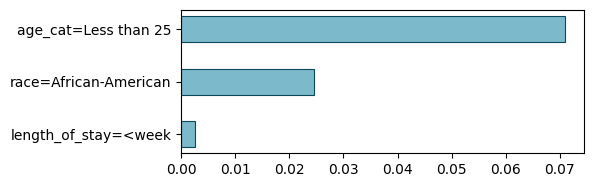

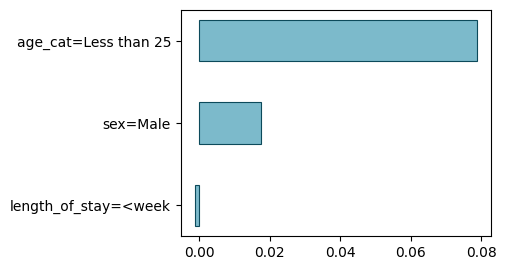

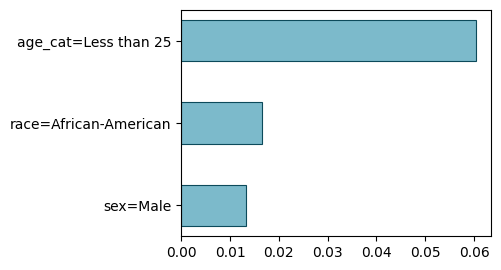

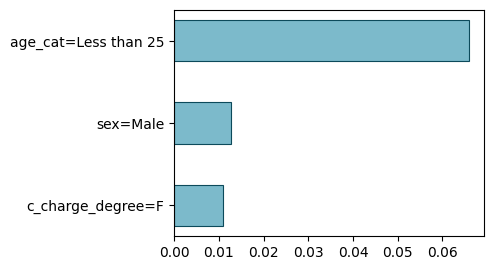

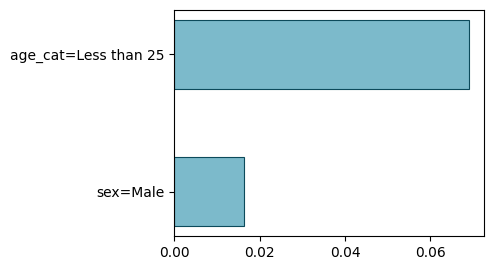

In [80]:
topK_ofI=fp_divergence_ofI.getDivergenceTopK(K=5, th_redundancy=0)
for item in topK_ofI.keys():
    fp_divergence_ofI.plotShapleyValue(item)

{frozenset({'age_cat=Less than 25', 'race=African-American', 'length_of_stay=<week'}): 0.09799222294232013}
{frozenset({'age_cat=Less than 25'}): 0.07096002527465936, frozenset({'race=African-American'}): 0.024541929986459078, frozenset({'length_of_stay=<week'}): 0.002490267681201678}


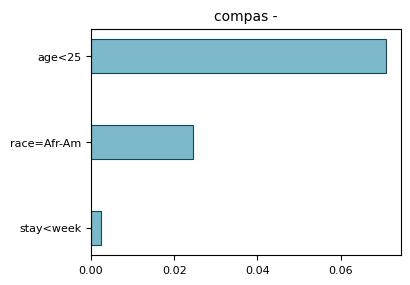

In [81]:
outputName=f"{outDirShap}/{dataset_name}_shap_{fp_divergence_ofI.metric_name}_{min_sup}"
itemset_div=fp_divergence_ofI.getDivergenceTopK(K=1, th_redundancy=0)
print(itemset_div)
itemset_shap=fp_divergence_ofI.computeShapleyValue(list(itemset_div.keys())[0])
print(itemset_shap)
fp_divergence_ofI.plotShapleyValue(shapley_values=itemset_shap, abbreviations=abbreviations,\
                 height=0.4,\
                 title=f"{dataset_name} -", sizeFig=(1.3,1.2), labelsize=8, saveFig=saveFig, nameFig=outputName)

#### Lattice Explorer

In [134]:
top1=list(fp_divergence_ofI.getDivergenceTopK(K=1, th_redundancy=0).keys())[0]
fig1=fp_divergence_ofI.plotLatticeItemset(top1, Th_divergence=0.15, sizeDot="small", getLower=True)

### Corrective

Given an itemset $I$ and an item $i \not\in I$, we say that $i$ is a *corrective item* for $I$ if 
$|\Delta(I \cup i)|<|\Delta(I)|$.


The *corrective factor* of $i$ w.r.t.\ $I$ is 
$|\Delta(I)| - |\Delta(I \cup i)|$.

In [83]:
#Significant corrective items based on t-value of difference
corrSign=fp_divergence_ofI.getCorrectiveItems()
corrSign.head(5)

,item i,S,S+i,v_i,v_S,v_S+i,t_value_corr,t_value_S+i,corr_factor
290,(race=African-American),"(priors_count=0, sex=Male)","(priors_count=0, race=African-American, sex=Male)",0.023913,-0.076534,-0.015379,2.776289,0.753259,0.061155
259,(race=African-American),"(length_of_stay=<week, priors_count=0)","(race=African-American, length_of_stay=<week, priors_count=0)",0.023913,-0.101443,-0.043215,2.955671,2.374896,0.058229
96,(race=African-American),(priors_count=0),"(race=African-American, priors_count=0)",0.023913,-0.092626,-0.039767,2.818701,2.287583,0.052860
295,"(priors_count=[1,3])","(length_of_stay=<week, c_charge_degree=M)","(priors_count=[1,3], length_of_stay=<week, c_charge_degree=M)",0.023711,-0.044867,0.007410,2.381362,0.385315,0.037457
244,(race=African-American),"(length_of_stay=<week, c_charge_degree=M)","(race=African-American, length_of_stay=<week, c_charge_degree=M)",0.023913,-0.044867,0.009307,2.676936,0.525724,0.035560


Only itemsets with positive divergence

In [84]:
corrSign_pos=fp_divergence_ofI.getCorrectiveItemsPos()
corrSign_pos.head()

,item i,S,S+i,v_i,v_S,v_S+i,t_value_corr,t_value_S+i,corr_factor
289,(priors_count=0),"(race=African-American, sex=Male)","(priors_count=0, race=African-American, sex=Male)",-0.092626,0.03879,-0.015379,2.54002,0.753259,0.023412


Details of $S$ and $S \cup i$ for the top corrective items

In [85]:
d=fp_divergence_ofI.getCorrectiveItems()
itemsetsOfI=d[["S", "S+i"]].head(4).values
for S,S_i in itemsetsOfI:
    display(fp_divergence_ofI.getInfoItemsets([S,S_i])[INFOS])

,support,itemsets,tn,tp,fn,fp,d_error,error,t_value_fp_fn
37,0.252430,"(priors_count=0, sex=Male)",1022,85,396,55,-0.076534,0.289474,5.862642
144,0.103046,"(priors_count=0, race=African-American, sex=Male)",360,53,184,39,-0.015379,0.350629,0.753259


,support,itemsets,tn,tp,fn,fp,d_error,error,t_value_fp_fn
23,0.303143,"(length_of_stay=<week, priors_count=0)",1309,67,434,61,-0.101443,0.264564,8.511401
121,0.122975,"(race=African-American, length_of_stay=<week, priors_count=0)",472,42,201,44,-0.043215,0.322793,2.374896


,support,itemsets,tn,tp,fn,fp,d_error,error,t_value_fp_fn
20,0.337816,(priors_count=0),1416,99,498,72,-0.092626,0.273381,8.023810
100,0.137071,"(race=African-American, priors_count=0)",509,61,227,49,-0.039767,0.326241,2.287583


,support,itemsets,tn,tp,fn,fp,d_error,error,t_value_fp_fn
24,0.301199,"(length_of_stay=<week, c_charge_degree=M)",1162,100,534,63,-0.044867,0.321140,3.595357
146,0.102398,"(priors_count=[1,3], length_of_stay=<week, c_charge_degree=M)",380,16,219,17,0.007410,0.373418,0.385315


#### Plot Shapley comparison corrective

In [86]:
from divexplorer.shapley_value_FPx import plotComparisonShapleyValues, compareShapleyValues, normalizeMax

,support,itemsets,tn,tp,fn,fp,d_error,error,t_value_fp_fn
37,0.252430,"(priors_count=0, sex=Male)",1022,85,396,55,-0.076534,0.289474,5.862642
144,0.103046,"(priors_count=0, race=African-American, sex=Male)",360,53,184,39,-0.015379,0.350629,0.753259


∇ERROR(S):-0.077 -->  ∇ERROR(S U i):-0.015


/home/eliana/Projects/DivExplorerG/divexplorer/divexplorer/shapley_value_FPx.py:412: UserWarning:

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations



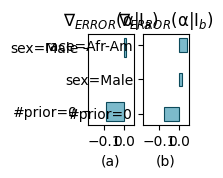

In [87]:
id_col=0
fp_divergence_ofI=fp_divergence_ofI
corrSign=fp_divergence_ofI.getCorrectiveItems()

if len(corrSign)>id_col:
    outputName=f"{outDirShap}/{dataset_name}_shap_corrective_{fp_divergence_ofI.metric_name}_{min_sup}"
    S,S_i, v_S, v_Si=corrSign[["S", "S+i", "v_S", "v_S+i"]].head(id_col+1).values[id_col].tolist()
    display(fp_divergence_ofI.getInfoItemsets([S,S_i])[INFOS])
    shap_itemset1=abbreviateDict(fp_divergence_ofI.computeShapleyValue(S), abbreviations)
    shap_itemset2=abbreviateDict(fp_divergence_ofI.computeShapleyValue(S_i), abbreviations)
    id1, id2="$_a$", "$_b$" 
    t1, t2=f"$∇_{{{fp_divergence_ofI.metric_name}}}$(α|I{id1})", f"$∇_{{{fp_divergence_ofI.metric_name}}}$(α|I{id2})"
    print(f"∇{fp_divergence_ofI.metric_name}(S):{round(v_S,3)} -->  ∇{fp_divergence_ofI.metric_name}(S U i):{round(v_Si,3)}")

    plotComparisonShapleyValues(shap_itemset1, shap_itemset2, height=[0.3, 0.4], sharedAxis=True, \
                        sizeFig=(5.2, 1.9), title=[t1,t2], saveFig=saveFig, nameFig=outputName, pad=1.5,\
                               metrics_name=[fp_divergence_ofI.metric_name, fp_divergence_ofI.metric_name])

#### Lattice

In [88]:
id_col=0
fp_divergence_ofI=fp_divergence_ofI
corrSign=fp_divergence_ofI.getCorrectiveItems()
if len(corrSign)>id_col:
    S_i=corrSign[["S+i"]].head(id_col+1).values[id_col][0]
    print(S_i)
    fig1=fp_divergence_ofI.plotLatticeItemset(S_i, Th_divergence=0.15, sizeDot="small", getLower=True)
    if saveFig:
        fig1.write_image(f"{outDirLattice}/lattice_corrective_{dataset_name}_{fp_divergence_ofI.metric_name}_{min_sup}.pdf")

frozenset({'priors_count=0', 'race=African-American', 'sex=Male'})


# Global

In [89]:
selectItemsInteractive(fp_divergence_ofI)

Button(description='Select items', style=ButtonStyle())

In [90]:
saveFig=saveFig
outDirGlobal="./results/figures/global"
if saveFig:
    createDir(outDirGlobal)

## Classification error

In [91]:
u_h_ofI=fp_divergence_ofI.computeGlobalShapleyValue()

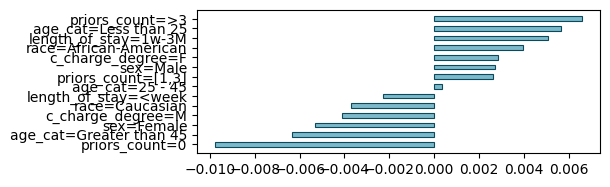

In [92]:
fp_divergence_ofI.plotShapleyValue(shapley_values=u_h_ofI,sizeFig=(5,6))

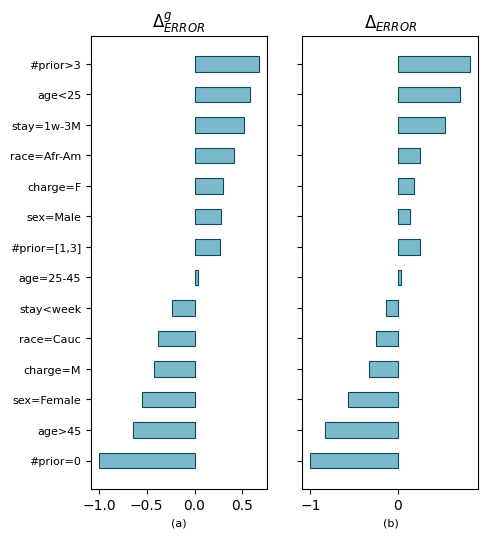

In [93]:
compareShapleyValues(normalizeMax(abbreviateDict(u_h_ofI, abbreviations)),\
                     normalizeMax(abbreviateDict(fp_divergence_ofI.getFItemsetsDivergence()[1], abbreviations)), \
                     title=[f"$\Delta^g_{{{fp_divergence_ofI.metric_name}}}$", f"$\Delta_{{{fp_divergence_ofI.metric_name}}}$"], \
                      labelsize=8, height=0.5, sizeFig=(6,5),\
                     saveFig=saveFig, subcaption=True,\
                     nameFig=f"{outDirGlobal}/{dataset_name}_{fp_divergence_ofI.metric_name}_shap_gl_compare_{min_sup}")

In [94]:
## Compare FPR,FNR

In [95]:
# compareShapleyValues(normalizeMax(abbreviateDict(u_h_ofI, abbreviations)), normalizeMax(abbreviateDict(u_h_fnr, abbreviations)), \
#                      title=[f"$\Delta^g_{{{fp_divergence_ofI.metric_name}}}$", f"$\Delta^g_{{{fp_divergence_fnr.metric_name}}}$"], \
#                       labelsize=8, height=0.5, sizeFig=(4,3), \
#                      saveFig=saveFig, subcaption=True,\
#                      nameFig=f"{outDirGlobal}/{dataset_name}_FPR_FNR_shap_gl_compare_{min_sup}")

## Top K Global plot

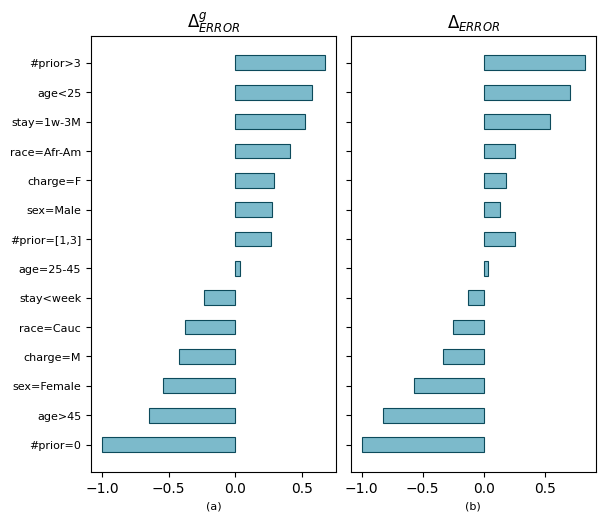

In [96]:
K=25
topK_global={k:v for k,v in u_h_ofI.items() if k in sorted(u_h_ofI, key=lambda x: abs(u_h_ofI[x]))[::-1][:K]}
topK_I_len1={k:v for k,v in fp_divergence_ofI.getFItemsetsDivergence()[1].items() if k in topK_global.keys()}

compareShapleyValues(normalizeMax(abbreviateDict(topK_global, abbreviations)),\
                     normalizeMax(abbreviateDict(topK_I_len1, abbreviations)), \
                     title=[f"$\Delta^g_{{{fp_divergence_ofI.metric_name}}}$", f"$\Delta_{{{fp_divergence_ofI.metric_name}}}$"], \
                      labelsize=8, height=0.5, sizeFig=(5,4),\
                     saveFig=saveFig, subcaption=True,\
                     pad=0.5,\
                     nameFig=f"{outDirGlobal}/{dataset_name}_{fp_divergence_ofI.metric_name}_shap_gl_compare_{min_sup}_top{K}")

## All metrics of interest

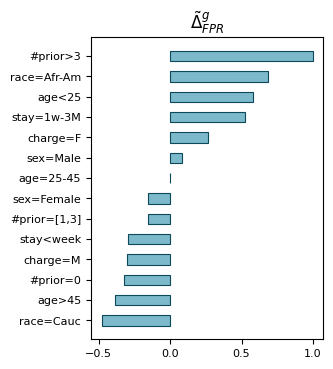

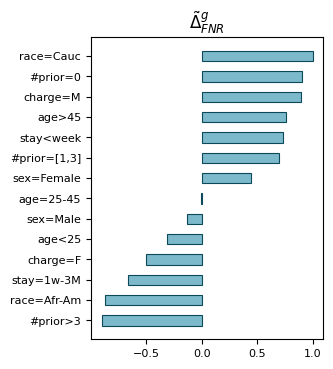

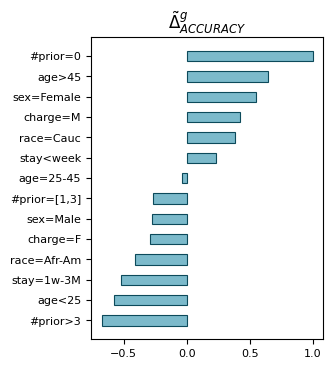

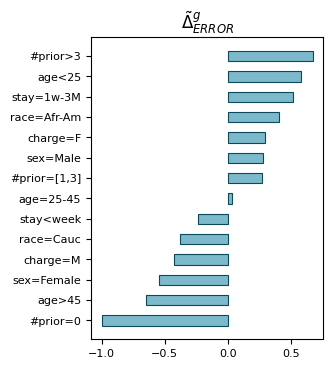

In [131]:
for metric_ofI in metrics:
    fp_divergence_ofI=FP_Divergence(FP_fm, metric_ofI)
    u_h_ofI=fp_divergence_ofI.computeGlobalShapleyValue()
    u_h_ofI_normalized=normalizeMax(abbreviateDict(u_h_ofI, abbreviations))
    title=rf"$\tilde{{Δ}}^g_{{{fp_divergence_ofI.metric_name}}}$"
    fp_divergence_ofI.plotShapleyValue(shapley_values=u_h_ofI_normalized,sizeFig=(3,4), title=title, labelsize=8, titlesize=12  )

## Top K terms

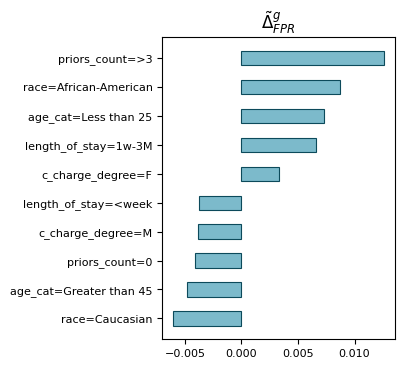

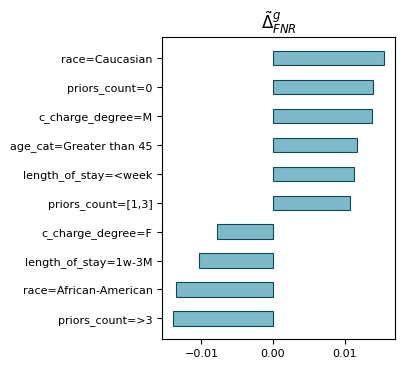

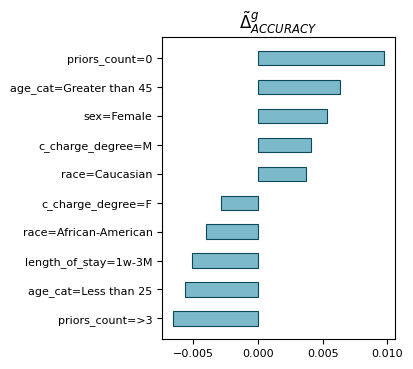

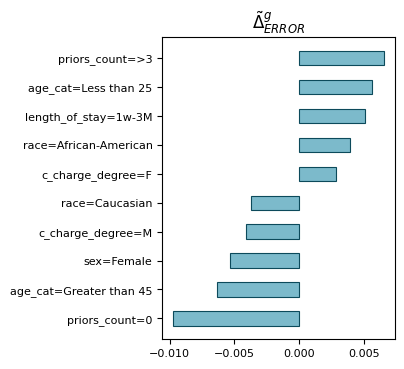

In [133]:
K=10

for metric_ofI in metrics:
    fp_divergence_ofI=FP_Divergence(FP_fm, metric_ofI)
    u_h_ofI=fp_divergence_ofI.computeGlobalShapleyValue()
    topK_global={k:v for k,v in u_h_ofI.items() if k in sorted(u_h_ofI, key=lambda x: abs(u_h_ofI[x]))[::-1][:K]}
    topK_global_normalized=normalizeMax(abbreviateDict(topK_global, abbreviations))
    title=rf"$\tilde{{Δ}}^g_{{{fp_divergence_ofI.metric_name}}}$"
    fp_divergence_ofI.plotShapleyValue(shapley_values=topK_global,sizeFig=(3,4), title=title, labelsize=8, titlesize=12  )